In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
mountpoint = '/content/drive'
drive.mount(mountpoint)
file_path = '/content/drive/My Drive/DF/서울교통공사_역별일별시간대별승하차인원정보_20231031.csv'



Mounted at /content/drive


In [ ]:
data=pd.read_csv(file_path,encoding='cp949')
data.head()
 #'수송일자'를 datetime 타입으로 변환하고 '요일' 컬럼 추가


,연번,수송일자,호선,역번호,역명,승하차구분,06시이전,06-07시간대,07-08시간대,08-09시간대,...,15-16시간대,16-17시간대,17-18시간대,18-19시간대,19-20시간대,20-21시간대,21-22시간대,22-23시간대,23-24시간대,24시이후
0,1,2023-01-01,1호선,150,서울역,승차,215,145,231,594,...,2655,2509,2696,2549,2462,2177,2190,1808,734,7
1,2,2023-01-01,1호선,150,서울역,하차,154,636,595,939,...,2282,2295,2526,1930,1897,1487,991,609,280,46
2,3,2023-01-01,1호선,151,시청,승차,48,73,106,194,...,843,895,959,985,670,630,515,330,146,0
3,4,2023-01-01,1호선,151,시청,하차,64,247,293,463,...,602,575,533,456,285,267,246,154,79,18
4,5,2023-01-01,1호선,152,종각,승차,407,235,158,201,...,1145,1402,1223,1272,911,913,906,602,232,3


#2호선

##사당

In [ ]:

# '수송일자'를 datetime으로 변환하고 '요일' 컬럼을 추가합니다.
data['수송일자'] = pd.to_datetime(data['수송일자'], format='%Y-%m-%d')
data['요일'] = data['수송일자'].dt.day_name()

# '사당'역 데이터 필터링
sadang_data = data[data['역명'] == '사당']

# 승차와 하차 인원 합계 계산
# 승차 인원 합계
sadang_on_total = sadang_data[sadang_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
# 하차 인원 합계
sadang_off_total = sadang_data[sadang_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

# 혼잡도 계산 (승차 인원 - 하차 인원)
congestion_sadang = sadang_on_total - sadang_off_total

# 혼잡도를 DataFrame으로 변환
congestion_sadang_df = congestion_sadang.reset_index()
congestion_sadang_df.columns = ['수송일자', '혼잡도']

# 2023년 데이터만 선택
congestion_sadang_2023 = congestion_sadang_df[congestion_sadang_df['수송일자'].dt.year == 2023]





<ipython-input-3-6d23fb769b40>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sadang_on_total = sadang_data[sadang_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-3-6d23fb769b40>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sadang_off_total = sadang_data[sadang_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


In [ ]:
# # 2023년 1월부터 9월까지의 혼잡도 데이터 선택
train_sadang_data = congestion_sadang_2023[(congestion_sadang_2023['수송일자'] >= '2023-01-01') & (congestion_sadang_2023['수송일자'] <= '2023-09-30')]

train_sadang_data=train_sadang_data['혼잡도']



In [ ]:
# arima 실행시 설치해야 함
# !pip install pmdarima
!pip install google-colab
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
import pandas as pd


# auto_arima를 사용하여 최적의 모델을 자동으로 찾습니다.
auto_model_sadang = auto_arima(train_sadang_data, seasonal=True, m=7 ,trace=True,
                        error_action='ignore', suppress_warnings=True)


# 10월의 혼잡도 예측
forecast_sadang = auto_model_sadang.predict(n_periods=31)

# 예측 결과 시각화 준비
forecast_index_sadang = pd.date_range(start='2023-10-01', periods=31, freq='D')
forecast_series_sadang = pd.Series(forecast_sadang, index=forecast_index_sadang)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4569.012, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4435.477, Time=0.97 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4452.236, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4567.016, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=4569.892, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=4402.993, Time=1.59 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=4365.951, Time=4.72 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=4360.893, Time=3.97 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=4499.137, Time=1.00 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=4363.085, Time=4.68 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=4470.960, Time=1.53 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4397.393, Time=0.98 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=4

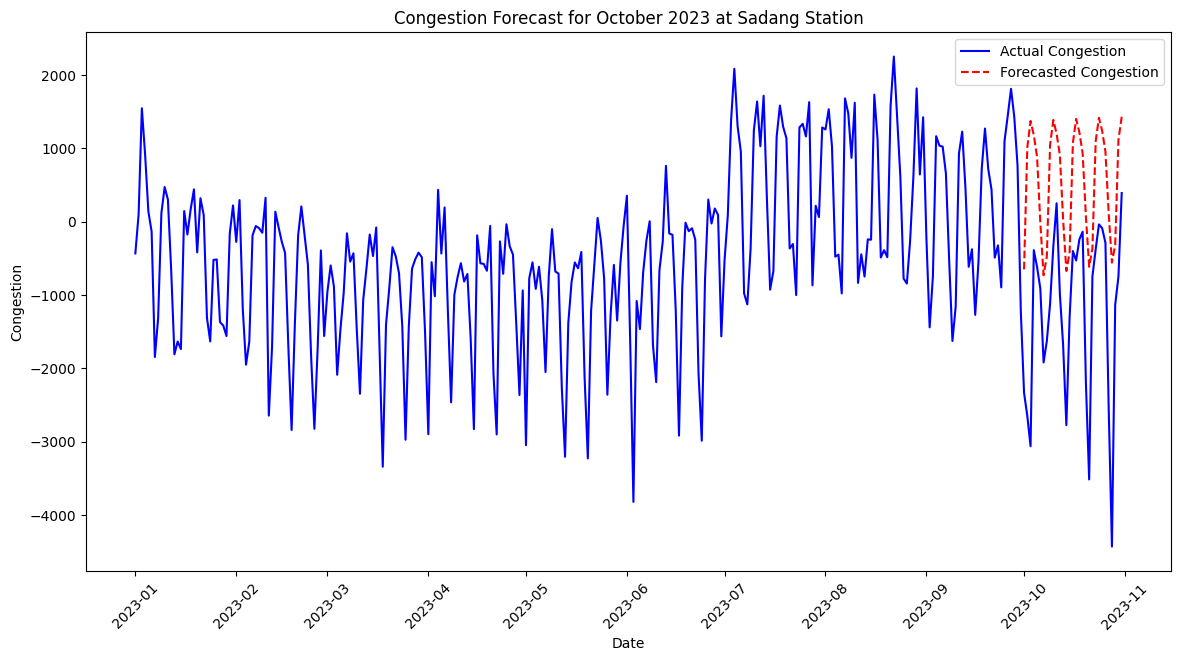

In [ ]:
# Convert forecast to a list to ignore its original index
forecast_values_sadang = forecast_sadang.tolist()

# Create forecast_series with the correct date index
forecast_series_sadang = pd.Series(forecast_values_sadang, index=forecast_index_sadang)

# Now, forecast_series should be correctly aligned with the dates
#print(forecast_series.head())

# Continue with plotting or analysis
plt.figure(figsize=(14, 7))
plt.plot(congestion_sadang_2023['수송일자'], congestion_sadang_2023['혼잡도'], label='Actual Congestion', color='blue')
plt.plot(forecast_series_sadang.index, forecast_series_sadang, label='Forecasted Congestion', color='red', linestyle='--')
plt.title('Congestion Forecast for October 2023 at Sadang Station')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()


##방배

In [ ]:

# '수송일자'를 datetime으로 변환하고 '요일' 컬럼을 추가합니다.
data['수송일자'] = pd.to_datetime(data['수송일자'], format='%Y-%m-%d')
data['요일'] = data['수송일자'].dt.day_name()

# '사당'역 데이터 필터링
bangbae_data = data[data['역명'] == '방배']

# 승차와 하차 인원 합계 계산
# 승차 인원 합계
bangbae_on_total = bangbae_data[bangbae_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
# 하차 인원 합계
bangbae_off_total = bangbae_data[bangbae_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

# 혼잡도 계산 (승차 인원 - 하차 인원)
congestion_bangbae = bangbae_on_total - bangbae_off_total

# 혼잡도를 DataFrame으로 변환
congestion_bangbae_df = congestion_bangbae.reset_index()
congestion_bangbae_df.columns = ['수송일자', '혼잡도']

# 2023년 데이터만 선택
congestion_bangbae_2023 = congestion_bangbae_df[congestion_bangbae_df['수송일자'].dt.year == 2023]





<ipython-input-8-02e6043d4fa6>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bangbae_on_total = bangbae_data[bangbae_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-8-02e6043d4fa6>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bangbae_off_total = bangbae_data[bangbae_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


In [ ]:
# # 2023년 1월부터 9월까지의 혼잡도 데이터 선택
train_bangbae_data = congestion_bangbae_2023[(congestion_bangbae_2023['수송일자'] >= '2023-01-01') & (congestion_bangbae_2023['수송일자'] <= '2023-09-30')]

train_bangbae_data=train_bangbae_data['혼잡도']



In [ ]:
from pmdarima import auto_arima
import pandas as pd


# auto_arima를 사용하여 최적의 모델을 자동으로 찾습니다.
auto_model_bangbae = auto_arima(train_bangbae_data, seasonal=True, m=7, trace=True,
                        error_action='ignore', suppress_warnings=True)

# 최적의 모델 요약 정보 출력
#print(auto_model.summary())

# 10월의 혼잡도 예측
forecast_bangbae = auto_model_bangbae.predict(n_periods=31)

# 예측 결과 시각화 준비
forecast_index_bangbae = pd.date_range(start='2023-10-01', periods=31, freq='D')
forecast_series_bangbae = pd.Series(forecast_bangbae, index=forecast_index_bangbae)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3856.286, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3751.768, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3742.200, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3854.294, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3803.701, Time=0.36 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=3707.047, Time=3.07 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.49 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=3795.087, Time=1.31 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=3688.879, Time=4.42 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=3717.086, Time=2.78 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.47 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=3771.407, Time=0

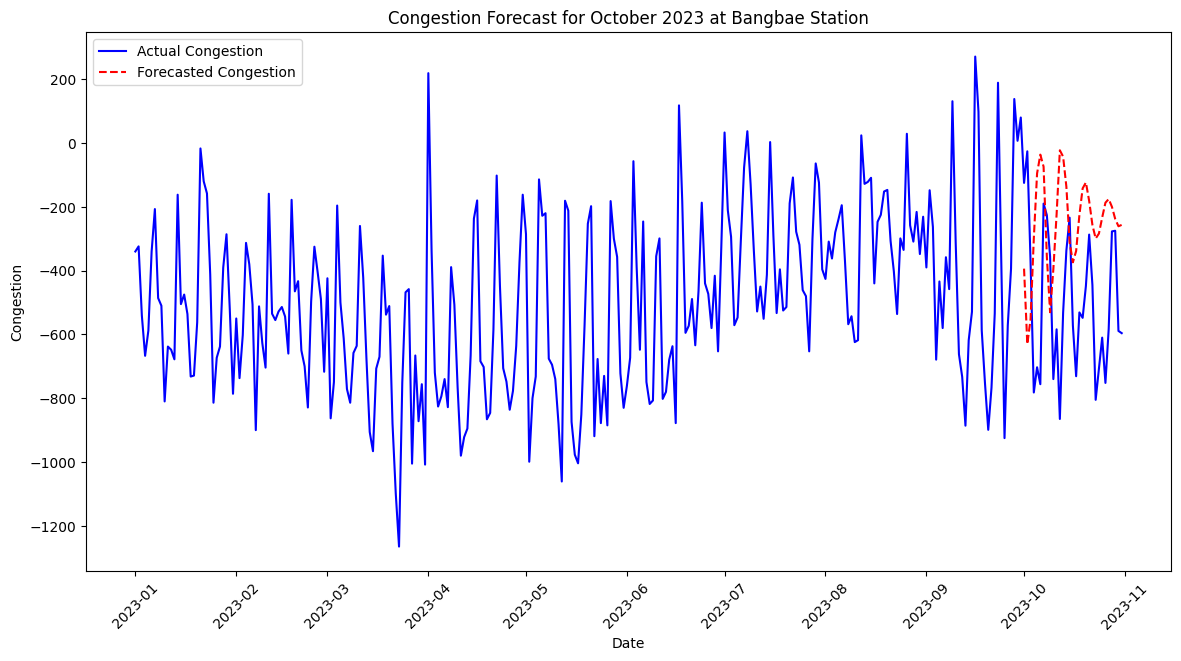

In [ ]:
# Convert forecast_bangbae to a list to ignore its original index
forecast_values_bangbae = forecast_bangbae.tolist()

# Create forecast_series with the correct date index
forecast_series_bangbae = pd.Series(forecast_values_bangbae, index=forecast_index_bangbae)

# Now, forecast_series should be correctly aligned with the dates
#print(forecast_series.head())

# Continue with plotting or analysis
plt.figure(figsize=(14, 7))
plt.plot(congestion_bangbae_2023['수송일자'], congestion_bangbae_2023['혼잡도'], label='Actual Congestion', color='blue')
plt.plot(forecast_series_bangbae.index, forecast_series_bangbae, label='Forecasted Congestion', color='red', linestyle='--')
plt.title('Congestion Forecast for October 2023 at Bangbae Station')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()


##서초

In [ ]:

# '수송일자'를 datetime으로 변환하고 '요일' 컬럼을 추가합니다.
data['수송일자'] = pd.to_datetime(data['수송일자'], format='%Y-%m-%d')
data['요일'] = data['수송일자'].dt.day_name()

# '사당'역 데이터 필터링
seocho_data = data[data['역명'] == '서초']

# 승차와 하차 인원 합계 계산
# 승차 인원 합계
seocho_on_total = seocho_data[seocho_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
# 하차 인원 합계
seocho_off_total = seocho_data[seocho_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

# 혼잡도 계산 (승차 인원 - 하차 인원)
congestion_seocho = seocho_on_total - seocho_off_total

# 혼잡도를 DataFrame으로 변환
congestion_seocho_df = congestion_seocho.reset_index()
congestion_seocho_df.columns = ['수송일자', '혼잡도']

# 2023년 데이터만 선택
congestion_seocho_2023 = congestion_seocho_df[congestion_seocho_df['수송일자'].dt.year == 2023]





<ipython-input-12-6fa49dc3061c>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seocho_on_total = seocho_data[seocho_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-12-6fa49dc3061c>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seocho_off_total = seocho_data[seocho_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


In [ ]:
# # 2023년 1월부터 9월까지의 혼잡도 데이터 선택
train_seocho_data = congestion_seocho_2023[(congestion_seocho_2023['수송일자'] >= '2023-01-01') & (congestion_seocho_2023['수송일자'] <= '2023-09-30')]

train_seocho_data=train_seocho_data['혼잡도']



In [ ]:
from pmdarima import auto_arima
import pandas as pd


# auto_arima를 사용하여 최적의 모델을 자동으로 찾습니다.
auto_model_seocho = auto_arima(train_seocho_data, seasonal=True, m=7, trace=True,
                        error_action='ignore', suppress_warnings=True)

# 최적의 모델 요약 정보 출력
#print(auto_model.summary())

# 10월의 혼잡도 예측
forecast_seocho = auto_model_seocho.predict(n_periods=31)

# 예측 결과 시각화 준비
forecast_index_seocho = pd.date_range(start='2023-10-01', periods=31, freq='D')
forecast_series_seocho = pd.Series(forecast_seocho, index=forecast_index_seocho)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4260.905, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4103.158, Time=0.70 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4154.876, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4614.657, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4230.414, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=4054.177, Time=1.99 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=4105.018, Time=1.65 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=4106.866, Time=2.25 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=4055.931, Time=3.70 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=4104.560, Time=2.55 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=4059.297, Time=1.54 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=4099.423, Time=1.82 sec
 ARIMA(1,0,0)(2,0,0)[7]             : AIC=4

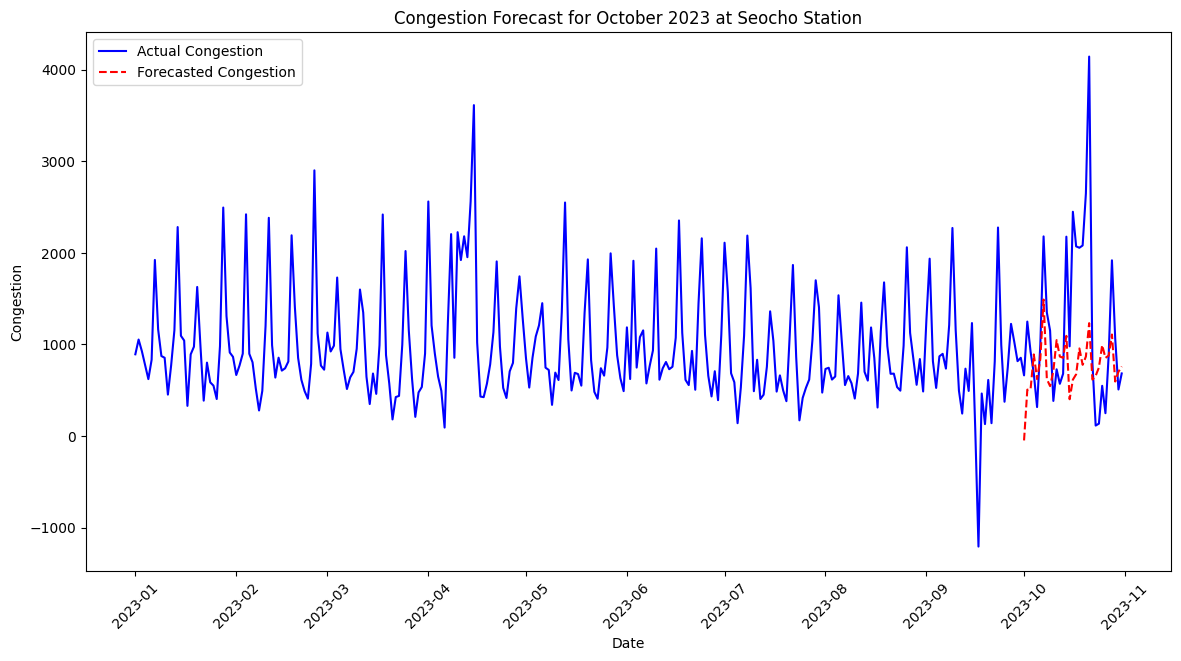

In [ ]:
# Convert forecast to a list to ignore its original index
forecast_values_seocho = forecast_seocho.tolist()

# Create forecast_series with the correct date index
forecast_series_seocho = pd.Series(forecast_values_seocho, index=forecast_index_seocho)

# Now, forecast_series should be correctly aligned with the dates
#print(forecast_series.head())

# Continue with plotting or analysis
plt.figure(figsize=(14, 7))
plt.plot(congestion_seocho_2023['수송일자'], congestion_seocho_2023['혼잡도'], label='Actual Congestion', color='blue')
plt.plot(forecast_series_seocho.index, forecast_series_seocho, label='Forecasted Congestion', color='red', linestyle='--')
plt.title('Congestion Forecast for October 2023 at Seocho Station')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## 예측

In [ ]:
forecast_df_sadang = pd.DataFrame({
    '수송일자': forecast_index_sadang,
    '예측 혼잡도': forecast_series_sadang
})

# 수송일자 컬럼을 활용하여 요일 정보 추가
forecast_df_sadang['요일'] = forecast_df_sadang['수송일자'].dt.day_name()
# 예측 결과와 날짜 인덱스를 포함하는 DataFrame 생성
forecast_df_sadang = pd.DataFrame({
    '수송일자': forecast_index_sadang,
    '예측 혼잡도': forecast_series_sadang
})
#forecast_df_sadang

In [ ]:
forecast_df_bangbae = pd.DataFrame({
    '수송일자': forecast_index_bangbae,
    '예측 혼잡도': forecast_series_bangbae
})

# 수송일자 컬럼을 활용하여 요일 정보 추가
forecast_df_bangbae['요일'] = forecast_df_bangbae['수송일자'].dt.day_name()
# 예측 결과와 날짜 인덱스를 포함하는 DataFrame 생성
forecast_df_bangbae = pd.DataFrame({
    '수송일자': forecast_index_bangbae,
    '예측 혼잡도': forecast_series_bangbae
})


In [ ]:
forecast_df_seocho = pd.DataFrame({
    '수송일자': forecast_index_seocho,
    '예측 혼잡도': forecast_series_seocho
})

# 수송일자 컬럼을 활용하여 요일 정보 추가
forecast_df_seocho['요일'] = forecast_df_seocho['수송일자'].dt.day_name()
# 예측 결과와 날짜 인덱스를 포함하는 DataFrame 생성
forecast_df_seocho = pd.DataFrame({
    '수송일자': forecast_index_seocho,
    '예측 혼잡도': forecast_series_seocho
})


In [ ]:
# 역 선택을 위한 함수 수정
def compare_stations_and_choose2(date):
    date_parsed = pd.to_datetime(date)
    # 날짜에 해당하는 혼잡도 조회
    congestion_seocho = forecast_df_seocho.loc[forecast_df_seocho['수송일자'] == date_parsed, '예측 혼잡도'].values[0]
    congestion_bangbae = forecast_df_bangbae.loc[forecast_df_bangbae['수송일자'] == date_parsed, '예측 혼잡도'].values[0]
    congestion_sadang = forecast_df_sadang.loc[forecast_df_sadang['수송일자'] == date_parsed, '예측 혼잡도'].values[0]

    print(f"{date} 의 서초역의 혼잡도 : {congestion_seocho}")
    print(f"{date} 의 방배역의 혼잡도 : {congestion_bangbae}")
    print(f"{date} 의 사당역의 혼잡도 : {congestion_sadang}")

    # 혼잡도 비교 및 추천 역 결정
    min_congestion, recommended_station = min(
        (congestion_seocho, "서초역"),
        (congestion_bangbae, "방배역"),
        (congestion_sadang, "사당역"),
        key=lambda pair: pair[0]
    )

    print(f"{date}에는 {recommended_station}이(가) 다른 역보다 혼잡도가 낮습니다. {recommended_station}을(를) 추천합니다.")

# 예시 사용
compare_stations_and_choose2('2023-10-01')


2023-10-01 의 서초역의 혼잡도 : -47.30313391678442
2023-10-01 의 방배역의 혼잡도 : -393.77283187170747
2023-10-01 의 사당역의 혼잡도 : -650.8550459790742
2023-10-01에는 사당역이(가) 다른 역보다 혼잡도가 낮습니다. 사당역을(를) 추천합니다.


#7호선

## 내방

In [ ]:
# 내방역 데이터 필터링
naebang_data = data[data['역명'] == '내방']

# 승차와 하차 인원 합계 계산
naebang_on_total = naebang_data[naebang_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
naebang_off_total = naebang_data[naebang_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

# 혼잡도 계산 (승차 인원 - 하차 인원)
congestion_naebang = naebang_on_total - naebang_off_total

# 혼잡도를 DataFrame으로 변환
congestion_naebang_df = congestion_naebang.reset_index()
congestion_naebang_df.columns = ['수송일자', '혼잡도']

# 2023년 데이터만 선택
congestion_naebang_2023 = congestion_naebang_df[congestion_naebang_df['수송일자'].dt.year == 2023]


<ipython-input-20-67e24dcf6618>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  naebang_on_total = naebang_data[naebang_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-20-67e24dcf6618>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  naebang_off_total = naebang_data[naebang_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4122.839, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3988.579, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3953.018, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4120.840, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3997.035, Time=0.29 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=3921.672, Time=1.23 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=4032.063, Time=0.45 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=3904.356, Time=1.65 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=3937.838, Time=0.77 sec
 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.19 s

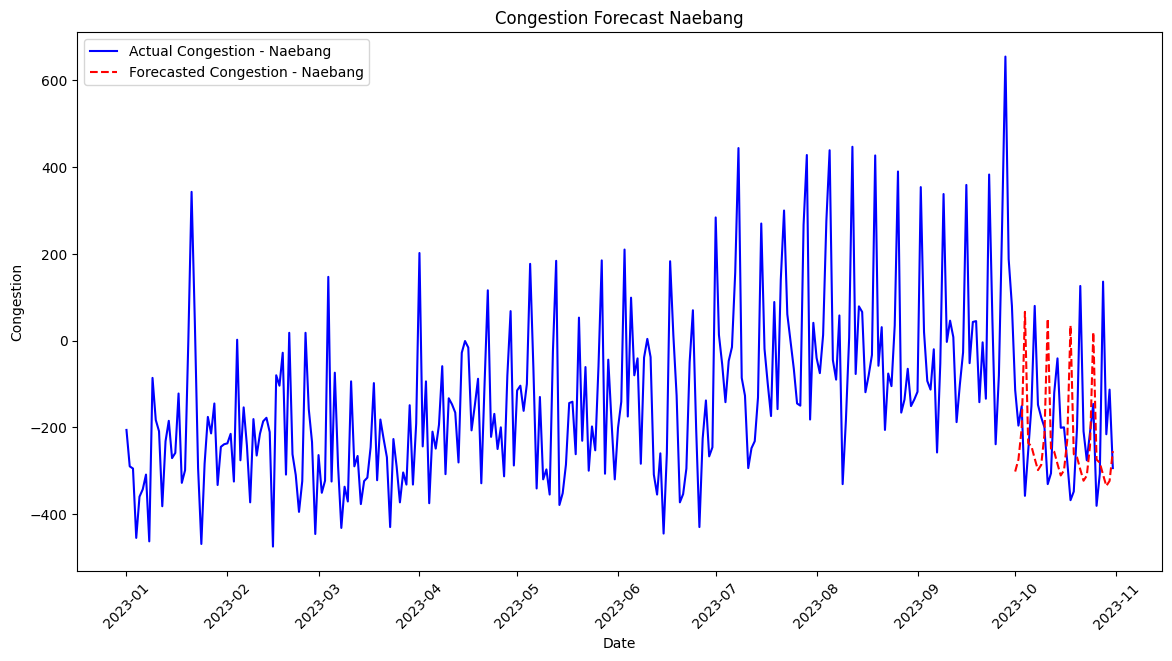

In [ ]:
# auto_arima를 사용하여 내방역 데이터에 대한 최적의 모델을 자동으로 찾습니다.
auto_model_naebang = auto_arima(congestion_naebang_2023['혼잡도'], seasonal=True, m=7, trace=True,
                                error_action='ignore', suppress_warnings=True)

# 10월의 혼잡도 예측
forecast_naebang = auto_model_naebang.predict(n_periods=31)

forecast_values = forecast_naebang.tolist()
forecast_index= pd.date_range(start='2023-10-01', periods=31, freq='D')

forecast_series_naebang = pd.Series(forecast_values, index=forecast_index)

# 예측 결과 시각화 준비
forecast_index_naebang = pd.date_range(start='2023-10-01', periods=31, freq='D')

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(congestion_naebang_2023['수송일자'], congestion_naebang_2023['혼잡도'], label='Actual Congestion - Naebang', color='blue')
plt.plot(forecast_series_naebang.index, forecast_series_naebang, label='Forecasted Congestion - Naebang', color='red', linestyle='--')
plt.title('Congestion Forecast Naebang')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()


##고속터미널

In [ ]:
# 고속터미널역 데이터 필터링
express_terminal_data = data[data['역명'] == '고속터미널']

# 승차와 하차 인원 합계 계산
express_terminal_on_total = express_terminal_data[express_terminal_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
express_terminal_off_total = express_terminal_data[express_terminal_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

# 혼잡도 계산 (승차 인원 - 하차 인원)
congestion_express_terminal = express_terminal_on_total - express_terminal_off_total

# 혼잡도를 DataFrame으로 변환
congestion_express_terminal_df = congestion_express_terminal.reset_index()
congestion_express_terminal_df.columns = ['수송일자', '혼잡도']

# 2023년 데이터만 선택
congestion_express_terminal_2023 = congestion_express_terminal_df[congestion_express_terminal_df['수송일자'].dt.year == 2023]


<ipython-input-22-511aed64484b>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  express_terminal_on_total = express_terminal_data[express_terminal_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-22-511aed64484b>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  express_terminal_off_total = express_terminal_data[express_terminal_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5934.496, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6169.937, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6029.261, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6001.449, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6353.424, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=5943.784, Time=0.82 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=5938.309, Time=0.87 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=5926.722, Time=1.01 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=5924.722, Time=0.93 sec
 ARIMA(1,0,2)(2,0,0)[7] intercept   : AIC=5927.657, Time=0.66 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=5930.408, Time=0.91 sec
 ARIMA(3,0,2)(2,0,0)[7] intercept   : AIC=5921.076, Time=2.02 sec
 ARIMA(3,0,2)(1,0,0)[7] intercept   : AIC=5936.142, Time=1.13 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=5922.903, Time=2.49 sec
 ARIMA(3,0,2)(1,0,1)[7] intercept

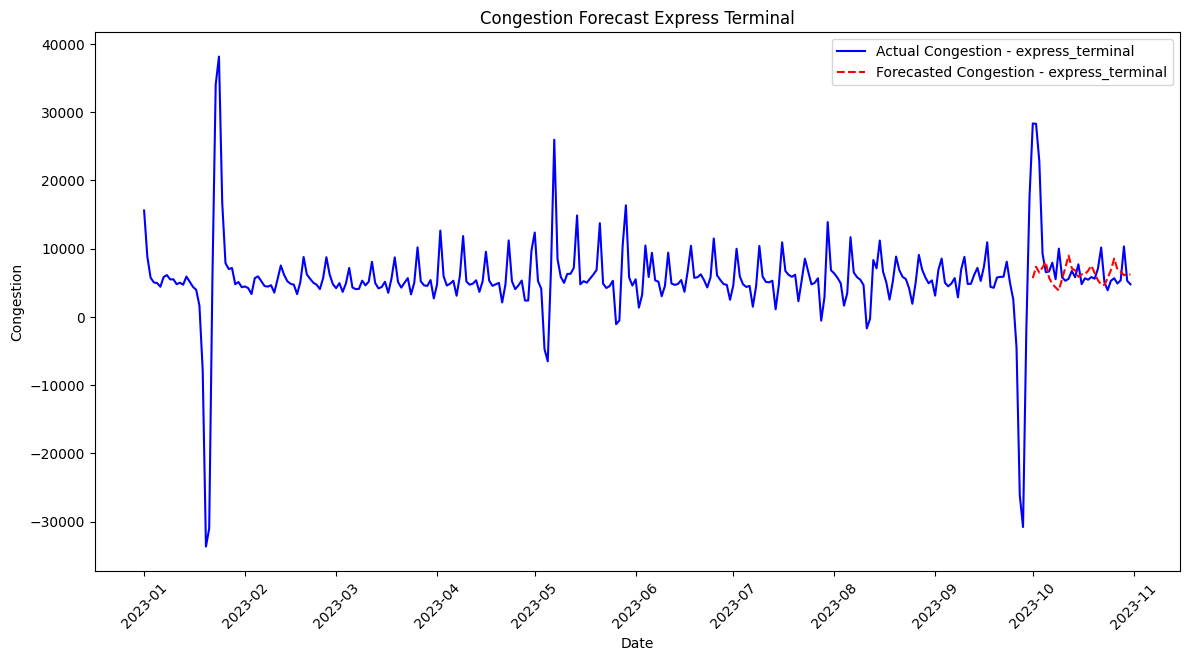

In [ ]:
# auto_arima를 사용하여 고속 터미널역 데이터에 대한 최적의 모델을 자동으로 찾습니다.
auto_model_express_terminal = auto_arima(congestion_express_terminal_2023['혼잡도'], seasonal=True, m=7, trace=True,
                                error_action='ignore', suppress_warnings=True)

# 10월의 혼잡도 예측
forecast_express_terminal = auto_model_express_terminal.predict(n_periods=31)

forecast_values = forecast_express_terminal.tolist()

# Create forecast_series with the correct date index
forecast_series_express_terminal = pd.Series(forecast_values, index=forecast_index)

# 예측 결과 시각화 준비
forecast_index_express_terminal = pd.date_range(start='2023-10-01', periods=31, freq='D')
#forecast_series_express_terminal = pd.Series(forecast_express_terminal, index=forecast_index_express_terminal)

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(congestion_express_terminal_2023['수송일자'], congestion_express_terminal_2023['혼잡도'], label='Actual Congestion - express_terminal', color='blue')
plt.plot(forecast_series_express_terminal.index, forecast_series_express_terminal, label='Forecasted Congestion - express_terminal', color='red', linestyle='--')
plt.title('Congestion Forecast Express Terminal')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()


##예측

In [ ]:
forecast_df_naebang = pd.DataFrame({
    '수송일자': forecast_index_naebang,
    '예측 혼잡도': forecast_series_naebang
})

# 수송일자 컬럼을 활용하여 요일 정보 추가
forecast_df_naebang['요일'] = forecast_df_naebang['수송일자'].dt.day_name()
# 예측 결과와 날짜 인덱스를 포함하는 DataFrame 생성
forecast_df_naebang = pd.DataFrame({
    '수송일자': forecast_index_naebang,
    '예측 혼잡도': forecast_series_naebang
})


In [ ]:
forecast_df_express_terminal = pd.DataFrame({
    '수송일자': forecast_index_express_terminal,
    '예측 혼잡도': forecast_series_express_terminal
})

# 수송일자 컬럼을 활용하여 요일 정보 추가
forecast_df_express_terminal['요일'] = forecast_df_express_terminal['수송일자'].dt.day_name()
# 예측 결과와 날짜 인덱스를 포함하는 DataFrame 생성
forecast_df_express_terminal = pd.DataFrame({
    '수송일자': forecast_index_express_terminal,
    '예측 혼잡도': forecast_series_express_terminal
})

# 수송일자 컬럼을 활용하여 요일 정보 추가
forecast_df_express_terminal['요일'] = forecast_df_express_terminal['수송일자'].dt.day_name()



In [ ]:

# 역 선택을 위한 함수 정의
def compare_stations_and_choose7(date):
    """
    주어진 날짜에 대해 두 역의 혼잡도를 비교하고, 더 낮은 혼잡도를 가진 역을 추천합니다.

    Parameters:
    - date: 조회하고자 하는 날짜 (예: '2023-10-15')
    """
    # 날짜에 해당하는 혼잡도 조회
    congestion_express = forecast_df_express_terminal[forecast_df_express_terminal['수송일자'] == date]['예측 혼잡도'].values[0]
    congestion_naebang = forecast_df_naebang[forecast_df_naebang['수송일자'] == date]['예측 혼잡도'].values[0]

    print(f"{date} 의 고속터미널역의 혼잡도 : {congestion_express} ")
    print(f"{date}의 내방역의 혼잡도 : {congestion_naebang} ")

    # 두 역의 혼잡도 비교
    if congestion_express < congestion_naebang:
        print(f"{date}에는 고속터미널역이 내방역보다 혼잡도가 낮습니다. 고속터미널역을 추천합니다.")
    elif congestion_express > congestion_naebang:
        print(f"{date}에는 내방역이 고속터미널역보다 혼잡도가 낮습니다. 내방역을 추천합니다.")
    else:
        print(f"{date}에는 두 역의 혼잡도가 같습니다. 어느 역을 선택해도 좋습니다.")

# 예시 사용
compare_stations_and_choose7('2023-10-13')


2023-10-13 의 고속터미널역의 혼잡도 : 7090.065030270969 
2023-10-13의 내방역의 혼잡도 : -256.4443839685449 
2023-10-13에는 내방역이 고속터미널역보다 혼잡도가 낮습니다. 내방역을 추천합니다.


3호선

종로3가

In [ ]:
data['수송일자'] = pd.to_datetime(data['수송일자'], format='%Y-%m-%d')
data['요일'] = data['수송일자'].dt.day_name()

jongro3_data = data[data['역명'] == '종로3가']

jongro3_on_total = jongro3_data[jongro3_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
jongro3_off_total = jongro3_data[jongro3_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

congestion_jongro3 = jongro3_on_total - jongro3_off_total

congestion_jongro3_df = congestion_jongro3.reset_index()
congestion_jongro3_df.columns = ['수송일자', '혼잡도']

congestion_jongro3_2023 = congestion_jongro3_df[congestion_jongro3_df['수송일자'].dt.year == 2023]


<ipython-input-27-7af054d22282>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  jongro3_on_total = jongro3_data[jongro3_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-27-7af054d22282>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  jongro3_off_total = jongro3_data[jongro3_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=4973.264, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5426.744, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5115.995, Time=1.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5424.747, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=5105.898, Time=2.81 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=5063.403, Time=1.50 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=5038.217, Time=2.88 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=4995.137, Time=3.54 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=5261.671, Time=0.73 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=5076.055, Time=3.89 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=5044.568, Time=3.57 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=4925.7

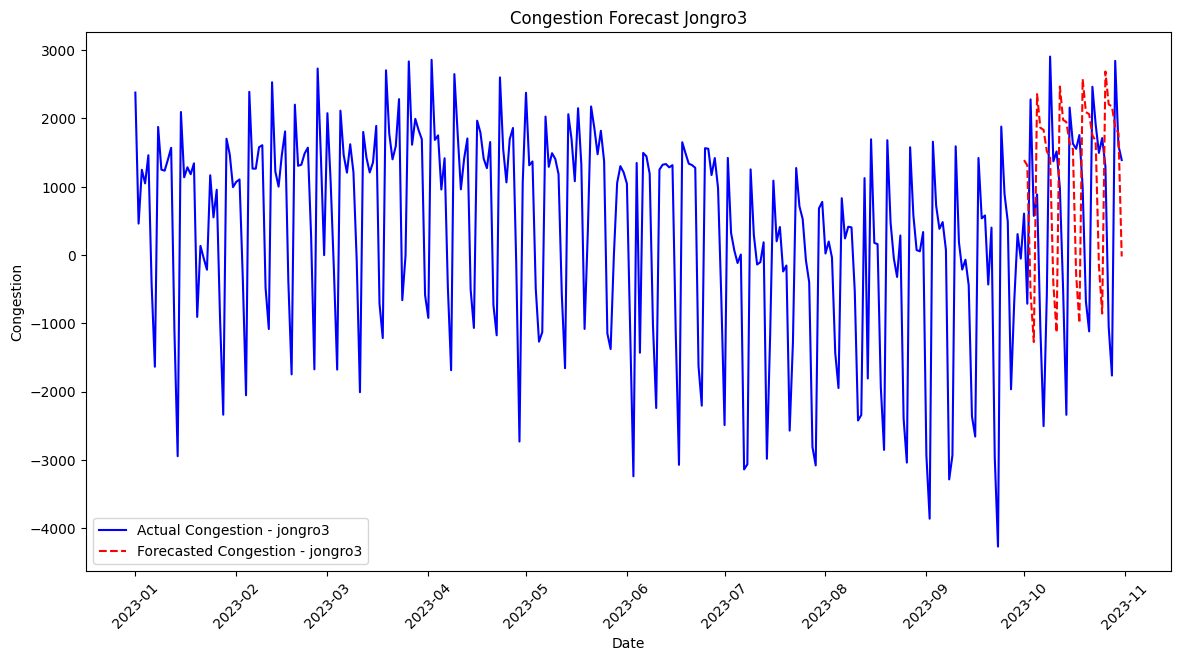

In [ ]:
auto_model_jongro3 = auto_arima(congestion_jongro3_2023['혼잡도'], seasonal=True, m=7, trace=True,
                                error_action='ignore', suppress_warnings=True)

forecast_jongro3 = auto_model_jongro3.predict(n_periods=31)

forecast_values = forecast_jongro3.tolist()
forecast_index= pd.date_range(start='2023-10-01', periods=31, freq='D')

forecast_series_jongro3 = pd.Series(forecast_values, index=forecast_index)

forecast_index_jongro3 = pd.date_range(start='2023-10-01', periods=31, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(congestion_jongro3_2023['수송일자'], congestion_jongro3_2023['혼잡도'], label='Actual Congestion - jongro3', color='blue')
plt.plot(forecast_series_jongro3.index, forecast_series_jongro3, label='Forecasted Congestion - jongro3', color='red', linestyle='--')
plt.title('Congestion Forecast Jongro3')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()


안국

In [ ]:
data['수송일자'] = pd.to_datetime(data['수송일자'], format='%Y-%m-%d')
data['요일'] = data['수송일자'].dt.day_name()

angook_data = data[data['역명'] == '안국']

angook_on_total = angook_data[angook_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
angook_off_total = angook_data[angook_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

congestion_angook = angook_on_total - angook_off_total

congestion_angook_df = congestion_angook.reset_index()
congestion_angook_df.columns = ['수송일자', '혼잡도']

congestion_angook_2023 = congestion_angook_df[congestion_angook_df['수송일자'].dt.year == 2023]

<ipython-input-29-f84aeee426c1>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  angook_on_total = angook_data[angook_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-29-f84aeee426c1>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  angook_off_total = angook_data[angook_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4965.995, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4876.866, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4787.793, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4964.009, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4800.862, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4750.984, Time=1.31 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=4782.754, Time=0.46 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4784.522, Time=1.28 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4775.485, Time=2.01 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=3.77 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4890.793, Time=0.98 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1

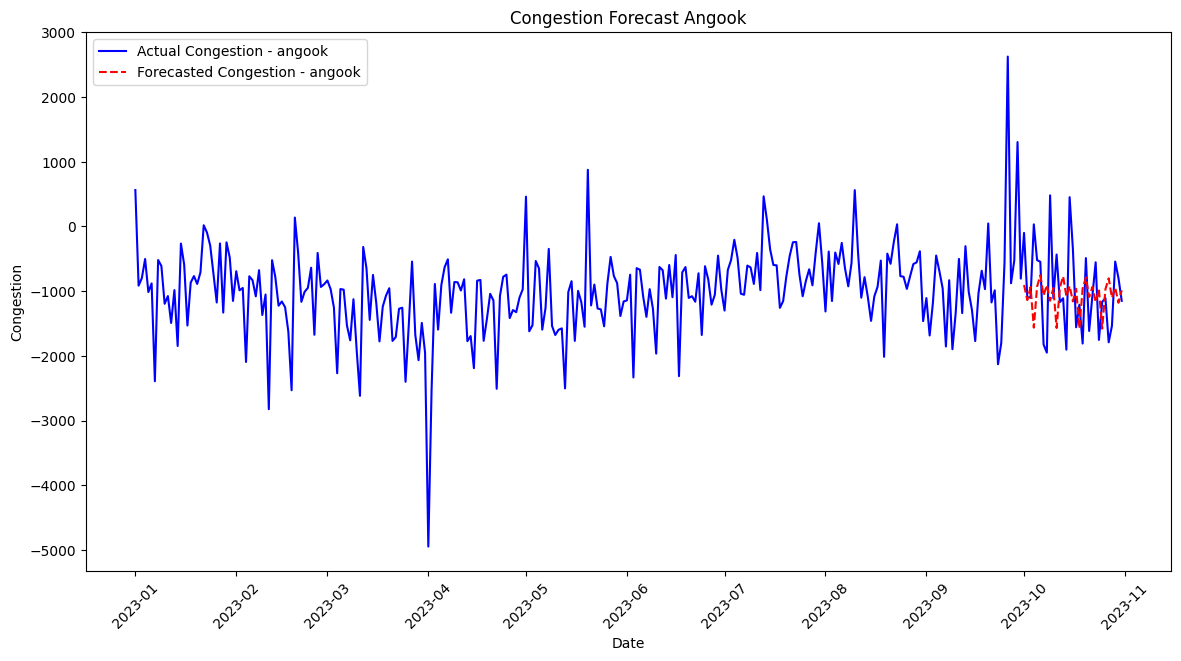

In [ ]:
auto_model_angook = auto_arima(congestion_angook_2023['혼잡도'], seasonal=True, m=7, trace=True,
                                error_action='ignore', suppress_warnings=True)
forecast_angook = auto_model_angook.predict(n_periods=31)

forecast_values = forecast_angook.tolist()
forecast_index= pd.date_range(start='2023-10-01', periods=31, freq='D')

forecast_series_angook = pd.Series(forecast_values, index=forecast_index)

forecast_index_angook = pd.date_range(start='2023-10-01', periods=31, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(congestion_angook_2023['수송일자'], congestion_angook_2023['혼잡도'], label='Actual Congestion - angook', color='blue')
plt.plot(forecast_series_angook.index, forecast_series_angook, label='Forecasted Congestion - angook', color='red', linestyle='--')
plt.title('Congestion Forecast Angook')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()

경복궁(정부서울청사)

In [ ]:
data['수송일자'] = pd.to_datetime(data['수송일자'], format='%Y-%m-%d')
data['요일'] = data['수송일자'].dt.day_name()

gyeongbok_data = data[data['역명'] == '경복궁(정부서울청사)']

gyeongbok_on_total = gyeongbok_data[gyeongbok_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
gyeongbok_off_total = gyeongbok_data[gyeongbok_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)

congestion_gyeongbok = gyeongbok_on_total - gyeongbok_off_total

congestion_gyeongbok_df = congestion_gyeongbok.reset_index()
congestion_gyeongbok_df.columns = ['수송일자', '혼잡도']

congestion_gyeongbok_2023 = congestion_gyeongbok_df[congestion_gyeongbok_df['수송일자'].dt.year == 2023]

<ipython-input-31-a4ae812507a3>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gyeongbok_on_total = gyeongbok_data[gyeongbok_data['승하차구분'] == '승차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)
<ipython-input-31-a4ae812507a3>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gyeongbok_off_total = gyeongbok_data[gyeongbok_data['승하차구분'] == '하차'].groupby('수송일자').sum().iloc[:, 2:24].sum(axis=1)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5001.754, Time=3.05 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5105.874, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5001.164, Time=0.75 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5018.172, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5150.120, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5047.502, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=5000.440, Time=1.01 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=5003.803, Time=2.12 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4983.225, Time=0.98 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=5010.565, Time=0.30 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=5004.656, Time=1.27 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=5006.724, Time=0.68 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=5034.289, Time=0.81 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : 

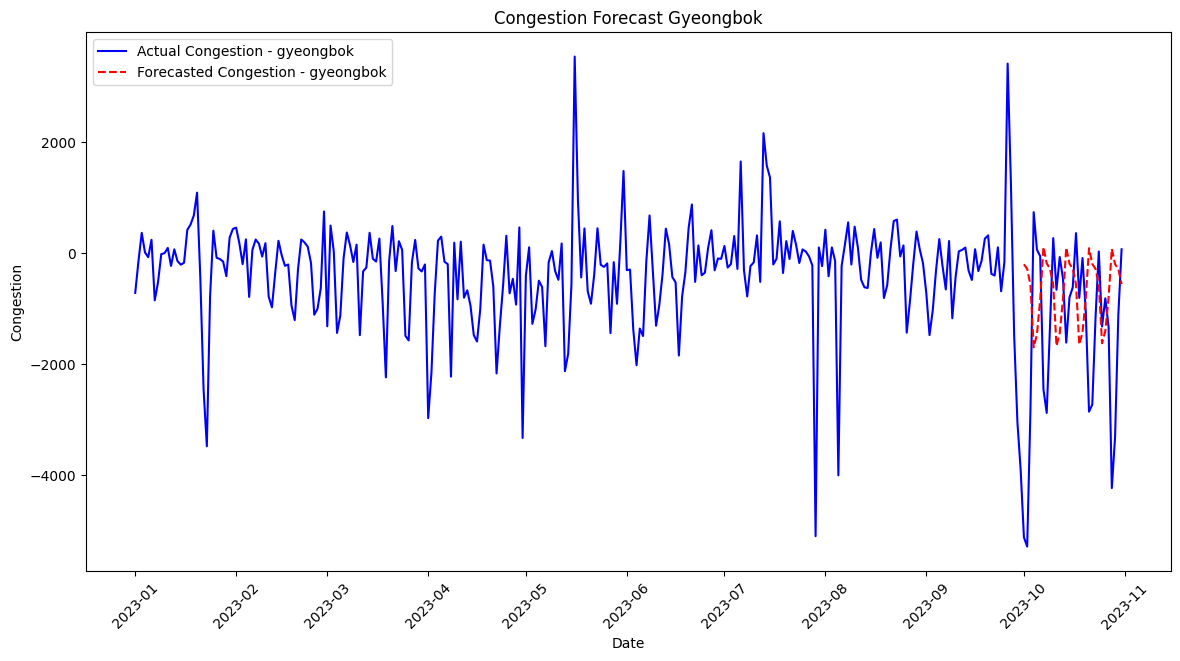

In [ ]:
auto_model_gyeongbok = auto_arima(congestion_gyeongbok_2023['혼잡도'], seasonal=True, m=7, trace=True,
                                error_action='ignore', suppress_warnings=True)
forecast_gyeongbok = auto_model_gyeongbok.predict(n_periods=31)

forecast_values = forecast_gyeongbok.tolist()
forecast_index= pd.date_range(start='2023-10-01', periods=31, freq='D')

forecast_series_gyeongbok = pd.Series(forecast_values, index=forecast_index)

forecast_index_gyeongbok = pd.date_range(start='2023-10-01', periods=31, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(congestion_gyeongbok_2023['수송일자'], congestion_gyeongbok_2023['혼잡도'], label='Actual Congestion - gyeongbok', color='blue')
plt.plot(forecast_series_gyeongbok.index, forecast_series_gyeongbok, label='Forecasted Congestion - gyeongbok', color='red', linestyle='--')
plt.title('Congestion Forecast Gyeongbok')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.legend()
plt.xticks(rotation=45)
plt.show()

예측

In [ ]:
forecast_df_jongro3 = pd.DataFrame({
    '수송일자': forecast_index_jongro3,
    '예측 혼잡도': forecast_series_jongro3
})

forecast_df_jongro3['요일'] = forecast_df_jongro3['수송일자'].dt.day_name()

forecast_df_jongro3 = pd.DataFrame({
    '수송일자': forecast_index_jongro3,
    '예측 혼잡도': forecast_series_jongro3
})

In [ ]:
forecast_df_angook = pd.DataFrame({
    '수송일자': forecast_index_angook,
    '예측 혼잡도': forecast_series_angook
})

forecast_df_angook['요일'] = forecast_df_angook['수송일자'].dt.day_name()

forecast_df_angook = pd.DataFrame({
    '수송일자': forecast_index_angook,
    '예측 혼잡도': forecast_series_angook
})

In [ ]:
forecast_df_gyeongbok = pd.DataFrame({
    '수송일자': forecast_index_gyeongbok,
    '예측 혼잡도': forecast_series_gyeongbok
})

forecast_df_gyeongbok['요일'] = forecast_df_gyeongbok['수송일자'].dt.day_name()

forecast_df_gyeongbok = pd.DataFrame({
    '수송일자': forecast_index_gyeongbok,
    '예측 혼잡도': forecast_series_gyeongbok
})

In [ ]:
# 역 선택을 위한 함수 정의
def compare_stations_and_choose3(date):
    """
    주어진 날짜에 대해 두 역의 혼잡도를 비교하고, 더 낮은 혼잡도를 가진 역을 추천합니다.

    Parameters:
    - date: 조회하고자 하는 날짜 (예: '2023-10-15')
    """
    # 날짜에 해당하는 혼잡도 조회
    congestion_jongro3 = forecast_df_jongro3[forecast_df_jongro3['수송일자'] == date]['예측 혼잡도'].values[0]
    congestion_angook = forecast_df_angook[forecast_df_angook['수송일자'] == date]['예측 혼잡도'].values[0]
    congestion_gyeongbok = forecast_df_gyeongbok[forecast_df_gyeongbok['수송일자'] == date]['예측 혼잡도'].values[0]

    print(f"{date} 의 종로3가역의 혼잡도 : {congestion_jongro3} ")
    print(f"{date}의 안국역의 혼잡도 : {congestion_angook} ")
    print(f"{date}의 경복궁역의 혼잡도 : {congestion_gyeongbok} ")

   # 혼잡도 비교 및 추천 역 결정
    min_congestion, recommended_station = min(
        (congestion_jongro3, "종로3가역"),
        (congestion_angook, "안국역"),
        (congestion_gyeongbok, "경복궁역"),
        key=lambda pair: pair[0]
    )

    print(f"{date}에는 {recommended_station}이(가) 다른 역보다 혼잡도가 낮습니다. {recommended_station}을(를) 추천합니다.")

# 예시 사용
compare_stations_and_choose3('2023-10-13')

2023-10-13 의 종로3가역의 혼잡도 : 1977.52920129517 
2023-10-13의 안국역의 혼잡도 : -771.0033369298524 
2023-10-13의 경복궁역의 혼잡도 : -823.4808935561306 
2023-10-13에는 경복궁역이(가) 다른 역보다 혼잡도가 낮습니다. 경복궁역을(를) 추천합니다.
